<a href="https://colab.research.google.com/github/lapshinaaa/applied-statistics-tasks/blob/main/AS6_Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="500">

# Bootstrap
</center>

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Task 1 (discrimination)

## 📖 Case Description: Verizon Repair Time Investigation  

**Verizon** is the primary regional telecommunications provider in the western United States, responsible for maintaining the local landline infrastructure (known as the *Incumbent Local Exchange Carrier*, or **ILEC**).  

In addition to its own services, Verizon also offered long-distance communication lines — just like several of its competitors, collectively referred to as *Competing Local Exchange Carriers* (**CLECs**).  

Whenever a malfunction occurred, Verizon was obligated to repair not only its own equipment but also that of its competitors. Crucially, it had to do so **at the same speed** — repair times for CLEC equipment were legally required to be no slower than for Verizon’s own infrastructure. The **Public Utilities Commission** monitored compliance with this rule.  

Over time, **suspicions arose** that Verizon was repairing its competitors’ equipment **more slowly** than its own. During regulatory hearings concerning these potential violations, **Tim Hesterberg**, the author of a well-known paper on the bootstrap, served as a consultant for Verizon.  

The Commission compared the repair times for Verizon’s own equipment versus CLEC equipment. For each case, they tested the **null hypothesis of equal mean repair times**, using a **significance level of 1%**.  

If more than 1% of these tests turned out significant, Verizon would face **heavy penalties**. The Commission initially relied on **t-tests** for comparing means, but following Hesterberg’s advice, Verizon proposed using **robust, nonparametric tests** — methods less sensitive to outliers and not reliant on the normality of the underlying distributions.  

In this assignment, we will approach the same question — whether Verizon systematically discriminated against competitors — using a **bootstrap approach**.  
We will:
- Construct a **confidence interval for the difference in medians**,  
- Check whether **zero lies within that interval**,  
- And use a **significance level of 1%**.  

The analysis will be done for **one CLEC company** and **Verizon**, simulating the original investigation.

### 🎯 Why We Check Whether Zero Lies Within the Confidence Interval  

We are building a **bootstrap confidence interval** for the **difference in medians** between two groups:  

$$
\Delta = \tilde{X}_{\text{Verizon}} - \tilde{X}_{\text{CLEC}}
$$

where each $\tilde{X}$ represents the sample **median repair time**.  

Using bootstrap resampling, we estimate the **sampling distribution** of $\Delta$ — how this difference would vary if we repeatedly collected new samples.  
From that, we construct the **99% confidence interval** (since $\alpha = 0.01$):

$$
CI_{99\%} = [ \Delta_{\text{low}}, \Delta_{\text{high}} ]
$$

---

#### 💡 Interpretation  

- The value **0** corresponds to **no difference in medians**:  
  $$
  H_0: \text{Median(Verizon)} = \text{Median(CLEC)}
  \quad \Rightarrow \quad \Delta = 0
  $$

- If **0 lies inside** the confidence interval, it means the observed difference could reasonably be explained by random variation.  
  → We **fail to reject $H_0$**: no statistically significant difference in repair times.  

- If **0 lies outside** the confidence interval, the difference is too large to be due to chance.  
  → We **reject $H_0$**: there is a statistically significant difference between Verizon and CLEC repair times.  

---

#### 🧠 Summary  

In this context, **zero represents the absence of discrimination** — equal typical (median) repair times.  
If the 99% bootstrap confidence interval for the median difference **excludes zero**, Verizon and CLEC repair times differ significantly at the 1% level.  
If **zero is included**, we have no evidence of such difference.


In [2]:
df = pd.read_csv('verizon.txt', sep='\t')
print(df.shape)

# ILEC - Verizion
# CLEC - внешние клиенты
df.head()

(1687, 2)


,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


Посмотрим на то, как распределено время ремонта для разных компаний, а также на число наблюдений, которым мы располагаем.

In [3]:
df.groupby('Group')['Time'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Group,,,,
CLEC,23,16.509130,14.33,19.503576
ILEC,1664,8.411611,3.59,14.690039


В данных есть существенный перекос в количестве наблюдений. Среднее время ремонта CLEC почти вдвое больше, чем для ILEC. Вопрос в том, является ли это свидетельством дискриминации. Если посмотреть на распределение, можно заметить, что распределение времени на ремонт CLEC имеет как минимум один выброс. Тем не менее, если смотреть на медианы, которые робастны (нечувствительны) к выбросам, ситуация, связанная со временем оказывается ещё более драмматичной.

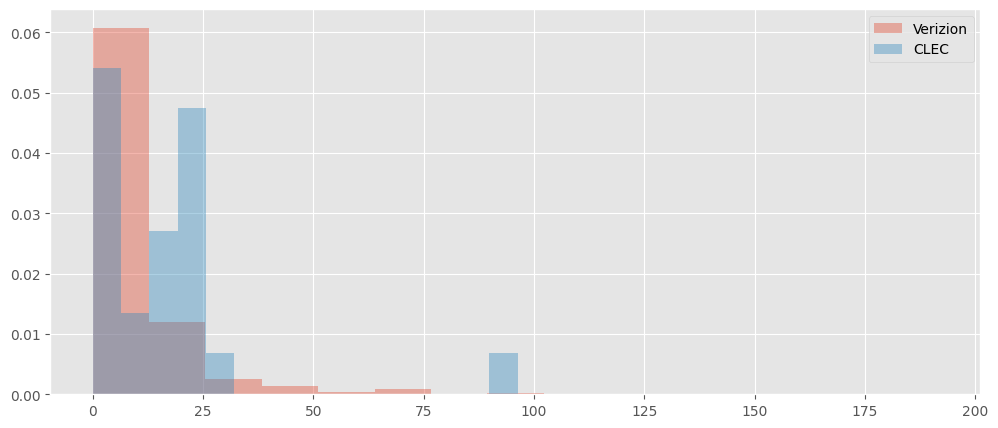

In [4]:
plt.figure(figsize=(12,5))
df[df.Group == 'ILEC'].Time.hist(bins=15, label='Verizion', alpha=0.4, density=True)
df[df.Group == 'CLEC'].Time.hist(bins=15, label='CLEC', alpha=0.4, density=True)
plt.legend();

__а) [2 балла]__ Постройте для разницы $med_{CLEC} - med_{Verizion}$ доверительный интервал Эфрона (перцентильный доверительный интервал).

In [10]:
verizon = df[df.Group == 'ILEC']["Time"]
clec = df[df.Group == 'CLEC']["Time"]

B_sample=10**4
alpha = 0.01
# collecting bootstrap differences in medians
boot_diffs = np.empty(B_sample)

rng = np.random.default_rng(seed=123456)

for sample in range(B_sample):
  sample_verizon = rng.choice(verizon, size=len(verizon), replace=True)
  sample_clec = rng.choice(clec, size=len(clec), replace=True)
  boot_diffs[sample] = np.median(sample_clec) - np.median(sample_verizon)

boot_diffs

array([ 4.63 , 16.215, 10.85 , ..., 14.47 ,  4.83 ,  5.02 ])

In [11]:
left = np.quantile(boot_diffs, alpha/2)
right = np.quantile(boot_diffs, 1-alpha/2)

In [12]:
left

np.float64(1.71)

In [13]:
# проверка того, что задание решено верно
assert left > 1.6
assert right < 20

# подобные тесты скрыты от вас

В целом, перцентильный интервал выглядит самым простым вариантом оценивания, однако в реальности он даёт весьма плохие результаты, так как сильно зависит от того насколько хорошо изначальная выборка аппроксимирует истинное распределение случайной величины. В данной ситуации из-за того, что исходное распределение асимметрично, мы получаем смещение.

__б) [2 балла]__ Постройте для разницы $med_{CLEC} - med_{Verizion}$ доверительный интервал Холла (обратный перцентильный доверительный интервал).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

left = ...
right = ...

# your code here


In [ ]:
# проверка того, что задание решено верно
assert left > 3
assert right < 22

# подобные тесты скрыты от вас

Холл в своей работе называл перцентильный интервал "the wrong pivot, backwards". Обратный перцентильный интервал для асимметричных распределений делает то же самое, но в обратном направлении.

__в) [2 балла]__ Постройте $t-$ перцентильный доверительный интервал:

1. Найдите точечную оценку неизвестного параметра (разность медиан) и точечную оценку стандартного отклонения
2. Сгенерируйте $10^5$ boostrap-выборок
3. Рассчитайте по каждой выбооке выборочную разницу медиан
4. Рассчитайте по каждой выборке стандартную ошибку
5. Найдите по каждой выборке $$t^* = \frac{\hat \theta^{*} - \hat{\theta}}{S^{*}}$$
6. Найдите для $t^{*}$ квантили уровня $0.05$ и $0.95$
7. Постройте доверительный интервал для разности медиан

В качестве $S^{*}$ исполизуйте сумму стандартных отклонений, посчитанных по выборкам $x$ и $y$. Конечно же, мы используем при таком подходе неправильное стандартное отклонение. При этом мы надеемся, что бутсрэп сам поправит нашу ошибку. При таком подходе главное, чтобы знаменатель сходился по вероятности к какому-нибудь пределу.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

theta_hat = ...
std_hat = ...

left = ...
right = ...

alpha = 0.01
# your code here


In [ ]:
# проверка того, что задание решено верно
assert left < 2
assert right > 20

# подобные тесты скрыты от вас

У $t$-bootstrap есть одно интересное свойство: он "уважает" асимметрию распределений при расчёте доверительных интервалов.

__г) [2 балла]__ Что в итоге? Есть ли дискриминация на рынке?

__Ответ:__

__д) [2 балла]__ Попробуйте оценить  $S^{*}$ с помощью двойного бутстрапа:

1. Бутстрапируем $B$ выборок
2. Для каждой сбутстрапированной выборки делаем ещё $B$ итераций бутстрапа, рассматривая эту выборку как исходную
3. По каждой выборке второго уровня находим асимметрию, подсчитываем по полученным асимметриям стандартное отклонение
4. Теперь у нас есть $B$ асимметрий и $B$ их стандартных отклонений
5. Стандартное отклонение, найденное по выборке асимметрий первого уровня мы будем использовать для подсчёта наблюдаемого значения статистики

Получается матрёшка из бутстрапов. Внутри каждого бутстрапа ещё $B$ бутсрапов. Изменились ли ваши выводы?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you